This notebook contains code that is good enough for demonstration purposes here, not fully tested code ready for real use.

In [3]:
cd(@__DIR__)
using Pkg
Pkg.activate(".")
Pkg.instantiate()

 Activating environment at `/Volumes/MyFiles/GitRepos/StatisticalMice/ProjectsPublic/Benchmarks/Project.toml`


In [4]:
Pkg.status()

Status `/Volumes/MyFiles/GitRepos/StatisticalMice/ProjectsPublic/Benchmarks/Project.toml`
  [6e4b80f9] BenchmarkTools v0.5.0
  [a93c6f00] DataFrames v0.22.4
  [31c24e10] Distributions v0.24.12
  [bdcacae8] LoopVectorization v0.10.0
  [91a5bcdd] Plots v1.10.2
  [b0e4dd01] RollingFunctions v0.6.2
  [c6e7a17c] SantasLittleHelpers v0.2.1
  [4c63dfa8] StaticKernels v0.5.1
  [ac1d9e8a] ThreadsX v0.1.7
  [9ff05d80] TickTock v1.1.0
  [bc48ee85] Tullio v0.2.11
  [9a3f8284] Random
  [10745b16] Statistics


In [5]:
# Set some notebook defaults
ENV["COLUMNS"] = 1000; ENV["LINES"] = 20;

# Display information about the environment
VERSION, Base.Threads.nthreads(), Base.Sys.CPU_THREADS

(v"1.5.3", 1, 8)

In [6]:
using Random, Distributions, BenchmarkTools, Tullio, LoopVectorization, DataFrames, StaticKernels, SantasLittleHelpers
using RollingFunctions, ThreadsX, Plots, Statistics

┌ Info: Precompiling Tullio [bc48ee85-29a4-5162-ae0b-a64e1601d4bc]
└ @ Base loading.jl:1278
┌ Info: Precompiling LoopVectorization [bdcacae8-1622-11e9-2a5c-532679323890]
└ @ Base loading.jl:1278
┌ Info: Precompiling StaticKernels [4c63dfa8-a427-4548-bd2f-4c19e87a7dc7]
└ @ Base loading.jl:1278
┌ Info: Precompiling SantasLittleHelpers [c6e7a17c-0287-4a42-9433-7fe3bf8697c3]
└ @ Base loading.jl:1278
┌ Info: Precompiling RollingFunctions [b0e4dd01-7b14-53d8-9b45-175a3e362653]
└ @ Base loading.jl:1278
┌ Info: Precompiling ThreadsX [ac1d9e8a-700a-412c-b207-f0111f4b6c0d]
└ @ Base loading.jl:1278
┌ Info: Precompiling Plots [91a5bcdd-55d7-5caf-9e0b-520d859cae80]
└ @ Base loading.jl:1278


In [7]:
w_size = 15 # window size for rolling average
N = 10^8
d = Normal()
df = DataFrame(:data => rand(d, N))
# df = DataFrame(data = ones(N))

,data
,Float64
1,-0.718387
2,-1.70469
3,-0.119375
4,0.964274
5,-1.14903
6,-0.898717
7,0.699986
8,1.03605
9,0.0552365


In [8]:
df[!, "sma_rf"] = runmean(df.data, w_size)
df

,data,sma_rf
,Float64,Float64
1,-0.718387,-0.718387
2,-1.70469,-1.21154
3,-0.119375,-0.847485
4,0.964274,-0.394545
5,-1.14903,-0.545443
6,-0.898717,-0.604322
7,0.699986,-0.417992
8,1.03605,-0.236237
9,0.0552365,-0.203851


In [9]:
# Calculate sma using StaticKernels and SantasLittleHelpers
# Contains code originally from Tyler Beason

k = makekernel(mean,-w_size+1:0)
df[!, "sma_sk"] = applyrolling(k, df.data)
df

,data,sma_rf,sma_sk
,Float64,Float64,Float64
1,-0.718387,-0.718387,-0.718387
2,-1.70469,-1.21154,-1.21154
3,-0.119375,-0.847485,-0.847485
4,0.964274,-0.394545,-0.394545
5,-1.14903,-0.545443,-0.545443
6,-0.898717,-0.604322,-0.604322
7,0.699986,-0.417992,-0.417992
8,1.03605,-0.236237,-0.236237
9,0.0552365,-0.203851,-0.203851


In [10]:
# Contains code originally from Michael Abbott

tmp = Array{Union{Missing, Float64}}(missing, length(df.data));

function f_tullio(data, sma, window_size)
    rate = 1/window_size
    out_view = @view sma[window_size:end]
    @tullio out_view[i] = rate*data[i+o]  o in 0:window_size-1  # verbose=true;
    sma
end

df[!, "sma_tullio"] = f_tullio(df.data, tmp, w_size)
df

,data,sma_rf,sma_sk,sma_tullio
,Float64,Float64,Float64,Float64?
1,-0.718387,-0.718387,-0.718387,missing
2,-1.70469,-1.21154,-1.21154,missing
3,-0.119375,-0.847485,-0.847485,missing
4,0.964274,-0.394545,-0.394545,missing
5,-1.14903,-0.545443,-0.545443,missing
6,-0.898717,-0.604322,-0.604322,missing
7,0.699986,-0.417992,-0.417992,missing
8,1.03605,-0.236237,-0.236237,missing
9,0.0552365,-0.203851,-0.203851,missing


In [11]:
# Contains code originally from Peter Deffebach

out = Vector{Union{Missing, Float64}}(undef, N)

function rollingmean_simd(x, m, out)
    N = length(x)
    out[1:(m-1)] .= missing
    sm = mean(@view x[1:m])
    out[m] = sm
    @inbounds @simd for i in (m+1):length(x)
        sm += (x[i] - x[i-m]) / m
        out[i] = sm
    end
    return out 
end

rollingmean_simd (generic function with 1 method)

In [12]:
df[!, "sma_simd"] = rollingmean_simd(df.data, w_size, out)
df

,data,sma_rf,sma_sk,sma_tullio,sma_simd
,Float64,Float64,Float64,Float64?,Float64?
1,-0.718387,-0.718387,-0.718387,missing,missing
2,-1.70469,-1.21154,-1.21154,missing,missing
3,-0.119375,-0.847485,-0.847485,missing,missing
4,0.964274,-0.394545,-0.394545,missing,missing
5,-1.14903,-0.545443,-0.545443,missing,missing
6,-0.898717,-0.604322,-0.604322,missing,missing
7,0.699986,-0.417992,-0.417992,missing,missing
8,1.03605,-0.236237,-0.236237,missing,missing
9,0.0552365,-0.203851,-0.203851,missing,missing


In [13]:
function rolling_average(v; window_size::Int=10)
    @assert window_size > 0
    loffset = window_size ÷ 2
    roffset = loffset + window_size%2
    ThreadsX.map(eachindex(v)) do i
        mean(@view v[max(begin, i-loffset) : min(end, i+roffset)])
    end
end

rolling_average (generic function with 1 method)

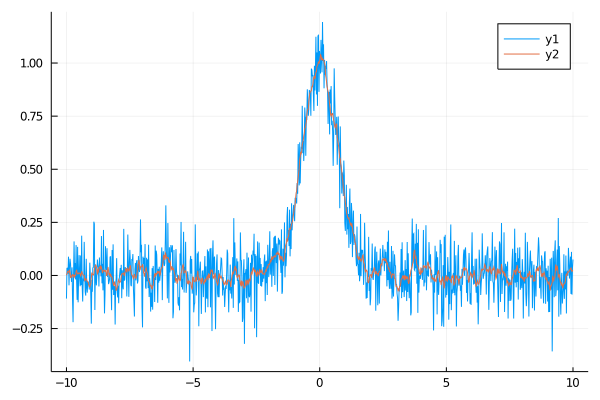

In [14]:
let xs = range(-10, 10, length=1000)
    ys = @. exp(-xs^2) + randn()/10
    plot(xs, ys)
    plot!(xs, rolling_average(ys))
end

In [15]:
df[!, "sma_tx"] = rolling_average(df.data, window_size=w_size)
df

,data,sma_rf,sma_sk,sma_tullio,sma_simd,sma_tx
,Float64,Float64,Float64,Float64?,Float64?,Float64
1,-0.718387,-0.718387,-0.718387,missing,missing,-0.203851
2,-1.70469,-1.21154,-1.21154,missing,missing,-0.106404
3,-0.119375,-0.847485,-0.847485,missing,missing,-0.0684736
4,0.964274,-0.394545,-0.394545,missing,missing,0.00508529
5,-1.14903,-0.545443,-0.545443,missing,missing,-0.00345076
6,-0.898717,-0.604322,-0.604322,missing,missing,0.0139026
7,0.699986,-0.417992,-0.417992,missing,missing,0.00762205
8,1.03605,-0.236237,-0.236237,missing,missing,0.0438826
9,0.0552365,-0.203851,-0.203851,missing,missing,0.179011


In [16]:
df.sma_rf[w_size:end] ≈ df.sma_sk[w_size:end]

true

In [17]:
df.sma_rf[w_size:end] ≈ df.sma_tullio[w_size:end]

true

In [18]:
df.sma_rf[w_size:end] ≈ df.sma_simd[w_size:end]

true

In [19]:
df.sma_rf[w_size:end] ≈ df.sma_tx[w_size:end]

false

In [20]:
@benchmark runmean(df.data, w_size)

BenchmarkTools.Trial: 
  memory estimate:  1.49 GiB
  allocs estimate:  6
  --------------
  minimum time:     2.288 s (0.18% GC)
  median time:      2.323 s (3.18% GC)
  mean time:        2.363 s (4.39% GC)
  maximum time:     2.478 s (9.41% GC)
  --------------
  samples:          3
  evals/sample:     1

In [21]:
k = makekernel(mean,-w_size+1:0)
@benchmark applyrolling(k, df.data)

BenchmarkTools.Trial: 
  memory estimate:  762.94 MiB
  allocs estimate:  2
  --------------
  minimum time:     1.099 s (0.16% GC)
  median time:      1.125 s (0.19% GC)
  mean time:        1.170 s (4.14% GC)
  maximum time:     1.307 s (12.35% GC)
  --------------
  samples:          5
  evals/sample:     1

In [22]:
@benchmark f_tullio(df.data, tmp, w_size)

BenchmarkTools.Trial: 
  memory estimate:  0 bytes
  allocs estimate:  0
  --------------
  minimum time:     814.067 ms (0.00% GC)
  median time:      837.555 ms (0.00% GC)
  mean time:        834.653 ms (0.00% GC)
  maximum time:     849.298 ms (0.00% GC)
  --------------
  samples:          6
  evals/sample:     1

In [23]:
@benchmark rollingmean_simd(df.data, w_size, out)

BenchmarkTools.Trial: 
  memory estimate:  0 bytes
  allocs estimate:  0
  --------------
  minimum time:     127.340 ms (0.00% GC)
  median time:      146.790 ms (0.00% GC)
  mean time:        145.819 ms (0.00% GC)
  maximum time:     153.840 ms (0.00% GC)
  --------------
  samples:          35
  evals/sample:     1

In [24]:
@benchmark rolling_average(df.data, window_size=w_size)

BenchmarkTools.Trial: 
  memory estimate:  2.41 GiB
  allocs estimate:  509
  --------------
  minimum time:     5.314 s (12.52% GC)
  median time:      5.314 s (12.52% GC)
  mean time:        5.314 s (12.52% GC)
  maximum time:     5.314 s (12.52% GC)
  --------------
  samples:          1
  evals/sample:     1

In [25]:
using Random, Distributions, BenchmarkTools, RollingFunctions, ThreadsX, DataFrames
function rolling_average(v; window_size::Int=10)
    @assert window_size > 0
    loffset = window_size ÷ 2
    roffset = loffset + window_size%2
    ThreadsX.map(eachindex(v)) do i
        mean(@view v[max(begin, i-loffset) : min(end, i+roffset)])
    end
end
N = 1000
d = Normal()
df = DataFrame(:data => rand(d, N))
df[!, "runmean"] = @btime runmean(df.data, 10)
df[!, "rolling_average"] = @btime rolling_average(df.data, window_size=10)
df.runmean[10:end] ≈ df.rolling_average[10:end]

  10.559 μs (4 allocations: 16.13 KiB)
  144.968 μs (347 allocations: 58.13 KiB)


false

In [26]:
df

,data,runmean,rolling_average
,Float64,Float64,Float64
1,-0.344762,-0.344762,-0.0711097
2,-0.144592,-0.244677,0.188784
3,1.18651,0.232386,0.226714
4,0.220532,0.229423,0.200555
5,0.548581,0.293254,0.1188
6,-1.89293,-0.0711097,0.0364702
7,1.74814,0.188784,0.0591603
8,0.492225,0.226714,0.130892
9,-0.0087148,0.200555,-0.224496
